In [33]:
import os
import warnings

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("✓ TOKENIZERS_PARALLELISM configurado a 'false' para evitar warnings")

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

print("✓ Configuración de warnings completada")

✓ TOKENIZERS_PARALLELISM configurado a 'false' para evitar warnings
✓ Configuración de warnings completada


# Modelado de Tópicos con FASTopic

Este notebook implementa un análisis de tópicos usando FASTopic sobre las opiniones turísticas clasificadas. Utiliza LangChain con GPT-4o-mini para asignar nombres semánticamente coherentes a los tópicos identificados y compara resultados con BERTopic.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
iimport os
import sys
from dotenv import load_dotenv

sys.path.append('../scripts')

from topicos import (
    configurar_clasificador_topicos, 
    configurar_fastopic_inteligente,
    LimpiadorTextoMejorado, 
    generar_reporte_limpieza, 
    mostrar_ejemplos_limpieza
)

from topicos.utils_topicos import (
    procesar_topicos_fastopic,
    obtener_asignaciones_topicos_fastopic,
    visualizar_distribucion_topicos_fastopic,
    mostrar_ejemplos_por_topico_fastopic,
    generar_reporte_fastopic
)

load_dotenv()

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [35]:
clasificador_topicos = configurar_clasificador_topicos()

In [36]:
CIUDAD_ANALIZAR = "Puerto_vallarta"
df = pd.read_csv('../data/processed/dataset_opiniones_analisis.csv')

if 'TopicoConFASTopic' not in df.columns:
    df['TopicoConFASTopic'] = np.nan

print(f"Dataset cargado: {df.shape[0]} opiniones")
print(f"Distribución total por ciudad:")
print(df['Ciudad'].value_counts())

df_ciudad = df[df['Ciudad'] == CIUDAD_ANALIZAR].copy()

columna_texto = 'TituloReviewLimpio'

texts = df_ciudad[columna_texto].dropna().tolist()

Dataset cargado: 2464 opiniones
Distribución total por ciudad:
Ciudad
Puebla             500
Mazatlan           500
Puerto_vallarta    491
Cdmx               490
Cancun             483
Name: count, dtype: int64


In [37]:
columna_limpia = "TituloReviewLimpio"

if columna_limpia not in df.columns:
    limpiador = LimpiadorTextoMejorado(idiomas=['spanish', 'english'])

    df_antes = df.copy()

    df = limpiador.limpiar_dataframe(
        df,
        columna_texto='TituloReview',
        nombre_columna_limpia=columna_limpia,
        aplicar_lematizacion=True,
        min_longitud_palabra=2,
        max_palabras=None
    )

    mostrar_ejemplos_limpieza(df, n_ejemplos=3)
    generar_reporte_limpieza(df_antes, df, 'TituloReview', columna_limpia)
    df.to_csv('../data/processed/dataset_opiniones_analisis.csv', index=False)

# Actualizar textos con la columna limpia
df_ciudad = df[df['Ciudad'] == CIUDAD_ANALIZAR].copy()
texts = df_ciudad[columna_texto].dropna().tolist()

In [38]:
# ===== CONFIGURACIÓN INTELIGENTE DE FASTOPIC =====
topic_model, reporte_optimizacion = configurar_fastopic_inteligente(texts)
    
print("🤖 Configuración automática de FASTopic completada")
print(reporte_optimizacion)

2025-09-17 12:34:49,089 - FASTopic - use device: cuda


🤖 Configuración automática de FASTopic completada

📊 CONFIGURACIÓN AUTOMÁTICA DE FASTOPIC

📈 Análisis del Corpus:
  📄 Documentos: 491
  📝 Palabras promedio por doc: 58.9
  🔤 Vocabulario único: 5,020
  🌈 Diversidad léxica: 0.173

🎯 Configuración Recomendada:
  🏷️ Número de tópicos: 10
  📚 Tamaño vocabulario: 5,020
  🧠 Memoria baja: No
  
  
⚙️ Hiperparámetros de Entrenamiento:
  🔄 Épocas: 100
  📚 Learning rate: 0.002
  🎛️ DT_alpha: 5.0
  🔧 Normalizar embeddings: No

💡 Razones de la Configuración:

🚀 Modelo FASTopic listo para entrenamiento con 100 épocas


In [39]:
print("\n🚀 Entrenando modelo FASTopic...")
inicio_entrenamiento = time.time()

# Obtener configuración de entrenamiento
training_config = getattr(topic_model, '_training_config', {'epochs': 100, 'learning_rate': 0.002})

# Entrenar el modelo
top_words, doc_topic_dist = topic_model.fit_transform(
    texts, 
    epochs=training_config['epochs'],
    learning_rate=training_config['learning_rate']
)

tiempo_entrenamiento = time.time() - inicio_entrenamiento

print(f"✅ Entrenamiento completado en {tiempo_entrenamiento:.2f} segundos")

2025-09-17 12:34:49,121 - FASTopic - First fit the model.



🚀 Entrenando modelo FASTopic...


parsing texts: 100%|██████████| 491/491 [00:00<00:00, 17819.69it/s]
2025-09-17 12:34:51,009 - TopMost - Real vocab size: 920
2025-09-17 12:34:51,010 - TopMost - Real training size: 491 	 avg length: 31.462
parsing texts: 100%|██████████| 491/491 [00:00<00:00, 17819.69it/s]
2025-09-17 12:34:51,009 - TopMost - Real vocab size: 920
2025-09-17 12:34:51,010 - TopMost - Real training size: 491 	 avg length: 31.462


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Training FASTopic:   8%|▊         | 8/100 [00:00<00:05, 16.67it/s]2025-09-17 12:34:52,981 - FASTopic - Epoch: 010 loss: 214.789
2025-09-17 12:34:52,981 - FASTopic - Epoch: 010 loss: 214.789
Training FASTopic:  19%|█▉        | 19/100 [00:01<00:08,  9.88it/s]2025-09-17 12:34:54,012 - FASTopic - Epoch: 020 loss: 206.749
2025-09-17 12:34:54,012 - FASTopic - Epoch: 020 loss: 206.749
Training FASTopic:  29%|██▉       | 29/100 [00:02<00:06, 10.65it/s]2025-09-17 12:34:54,993 - FASTopic - Epoch: 030 loss: 200.670
2025-09-17 12:34:54,993 - FASTopic - Epoch: 030 loss: 200.670
Training FASTopic:  39%|███▉      | 39/100 [00:03<00:06,  9.92it/s]2025-09-17 12:34:56,022 - FASTopic - Epoch: 040 loss: 197.088
2025-09-17 12:34:56,022 - FASTopic - Epoch: 040 loss: 197.088
Training FASTopic:  69%|██████▉   | 69/100 [00:07<00:03,  7.94it/s]2025-09-17 12:34:59,904 - FASTopic - Epoch: 070 loss: 190.877
2025-09-17 12:34:59,904 - FASTopic - Epoch: 070 loss: 190.877
Training FASTopic: 100%|██████████| 100/100 [0

Topic 0: que como una las pero por mas ciudad este del nos san durante los pancho
Topic 1: guias subir cima caminata amables subida escaleras experiencia super recomendado ejercicio vista empinada manana atentos
Topic 2: bahia hotel puerto centro nuevo nayarit etc lujo delfines sido destino piscina aves dicen noviembre
Topic 3: romantica restaurantes restaurante bares deportivo barcos servicios clubes ropa ocupado vibrante cocina agradables tiendas artistas
Topic 4: church inside cream walking boardwalk view awesome visited find show several make lot gay visiting
Topic 5: the and for bay was beach there were are from you with this great our
Topic 6: playas olas arena playa oleaje tranquilo limpia condominios bajar tranquilidad clara sombra suave cristalina peor
Topic 7: maravillosa hermoso absolutamente maravilloso arquitectura peces misa ingles geniales costa estadia detenerse interesante zonas turisticos
Topic 8: espectacular espectaculares adriel serviciales ampliamente experiencias

In [40]:
# ===== PROCESAMIENTO DE TÓPICOS FASTOPIC =====
topic_info = procesar_topicos_fastopic(topic_model, doc_topic_dist, top_words)

topic_names = {}
for _, row in topic_info.iterrows():
    topic_id = row['Topic']
    keywords = row['Keywords']
    
    if keywords and keywords not in ["Sin palabras", "Error en procesamiento"]:
        resultado = clasificador_topicos.invoke({"keywords": keywords})
        topic_names[topic_id] = resultado.nombre_topico
        print(f"Tópico {topic_id}: {topic_names[topic_id]}")
    else:
        topic_names[topic_id] = f"Tópico {topic_id}"

topic_info['Name'] = topic_info['Topic'].map(topic_names)

Tópico 0: Experiencias en la ciudad
Tópico 1: Caminatas guiadas amables
Tópico 1: Caminatas guiadas amables
Tópico 2: Lujo en Destinos Costeros
Tópico 2: Lujo en Destinos Costeros
Tópico 3: Vida Nocturna Romántica
Tópico 3: Vida Nocturna Romántica
Tópico 4: Experiencias culturales y vistas
Tópico 4: Experiencias culturales y vistas
Tópico 5: Playas y bahías
Tópico 5: Playas y bahías
Tópico 6: Experiencia en playas tranquilas
Tópico 6: Experiencia en playas tranquilas
Tópico 7: Belleza arquitectónica y natural
Tópico 7: Belleza arquitectónica y natural
Tópico 8: Experiencias Espectaculares
Tópico 8: Experiencias Espectaculares
Tópico 9: Experiencias familiares culturales
Tópico 9: Experiencias familiares culturales


In [41]:
# Obtener asignaciones de tópicos para documentos
topic_assignments, topic_names_assigned, topic_probabilities = obtener_asignaciones_topicos_fastopic(
    doc_topic_dist, 
    topic_names, 
    threshold=0.1
)

# Procesar solo datos de la ciudad seleccionada
df_con_topicos = df_ciudad.dropna(subset=[columna_texto]).copy()
df_con_topicos['Topico'] = topic_assignments
df_con_topicos['Topico_Nombre'] = topic_names_assigned
df_con_topicos['Probabilidad_Topico'] = topic_probabilities

# Verificar si la ciudad ya tenía resultados previos
indices_ciudad = df_con_topicos.index
opiniones_previas = df.loc[indices_ciudad, 'TopicoConFASTopic'].notna().sum()

if opiniones_previas > 0:
    print(f"🔄 SOBRESCRIBIENDO resultados previos para {CIUDAD_ANALIZAR}:")
    print(f"   📝 Opiniones con tópicos previos: {opiniones_previas}")
    print(f"   🆕 Nuevas asignaciones de tópicos: {len(df_con_topicos)}")
else:
    print(f"🆕 PRIMERA VEZ procesando {CIUDAD_ANALIZAR}:")
    print(f"   📝 Nuevas asignaciones de tópicos: {len(df_con_topicos)}")

# Actualizar el dataset original con los tópicos de la ciudad analizada
df.loc[indices_ciudad, 'TopicoConFASTopic'] = df_con_topicos['Topico_Nombre']

print(f"\n✅ Actualización completada para {CIUDAD_ANALIZAR}")
print(f"Distribución de tópicos en {CIUDAD_ANALIZAR}:")
topico_counts = df_con_topicos['Topico_Nombre'].value_counts()
print(topico_counts)

print(f"\nPorcentaje de opiniones por tópico en {CIUDAD_ANALIZAR}:")
topico_pct = (topico_counts / len(df_con_topicos) * 100).round(2)
for topico, pct in topico_pct.items():
    print(f"{topico}: {pct}%")

print(f"\nEstado actualización dataset completo:")
print(f"Total opiniones: {len(df)}")
print(f"Opiniones con tópico FASTopic asignado: {df['TopicoConFASTopic'].notna().sum()}")
print(f"Opiniones pendientes: {df['TopicoConFASTopic'].isna().sum()}")

🔄 SOBRESCRIBIENDO resultados previos para Puerto_vallarta:
   📝 Opiniones con tópicos previos: 491
   🆕 Nuevas asignaciones de tópicos: 491

✅ Actualización completada para Puerto_vallarta
Distribución de tópicos en Puerto_vallarta:
Topico_Nombre
Caminatas guiadas amables             88
Vida Nocturna Romántica               83
Experiencia en playas tranquilas      76
Playas y bahías                       64
Belleza arquitectónica y natural      49
Experiencias Espectaculares           34
Lujo en Destinos Costeros             34
Experiencias familiares culturales    31
Experiencias en la ciudad             20
Experiencias culturales y vistas      12
Name: count, dtype: int64

Porcentaje de opiniones por tópico en Puerto_vallarta:
Caminatas guiadas amables: 17.92%
Vida Nocturna Romántica: 16.9%
Experiencia en playas tranquilas: 15.48%
Playas y bahías: 13.03%
Belleza arquitectónica y natural: 9.98%
Experiencias Espectaculares: 6.92%
Lujo en Destinos Costeros: 6.92%
Experiencias familiares

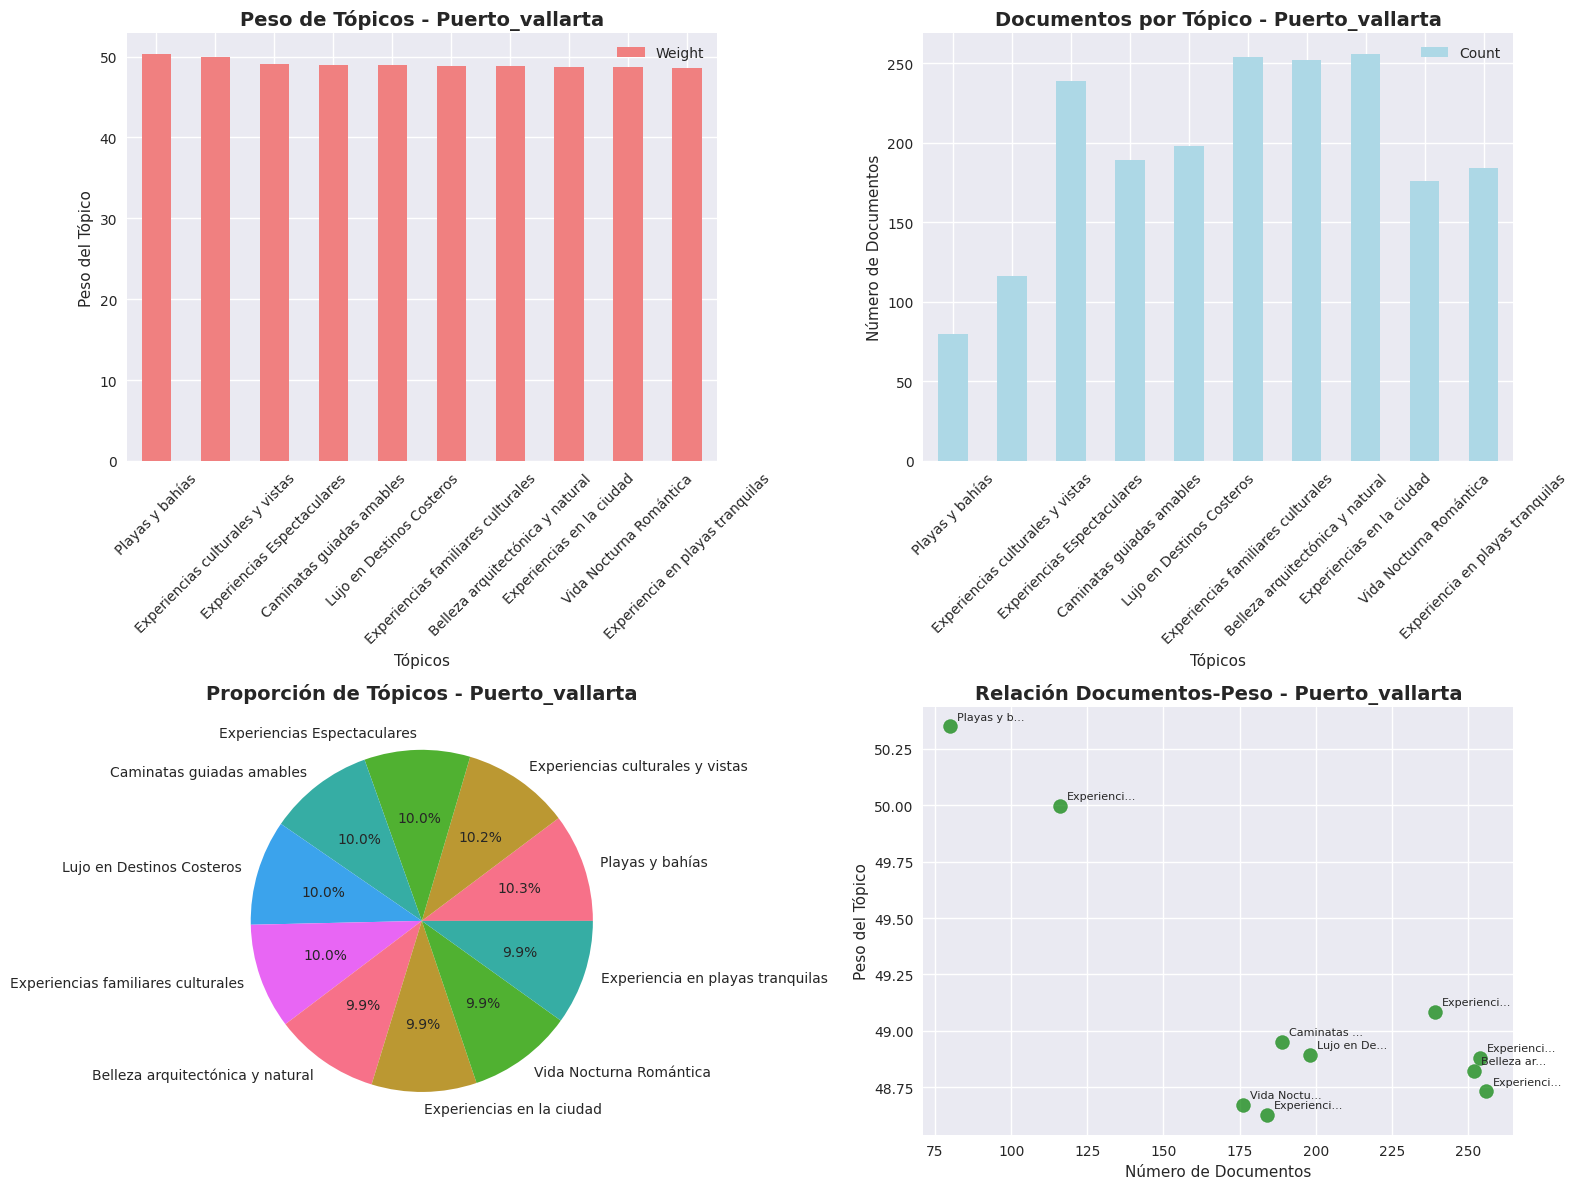

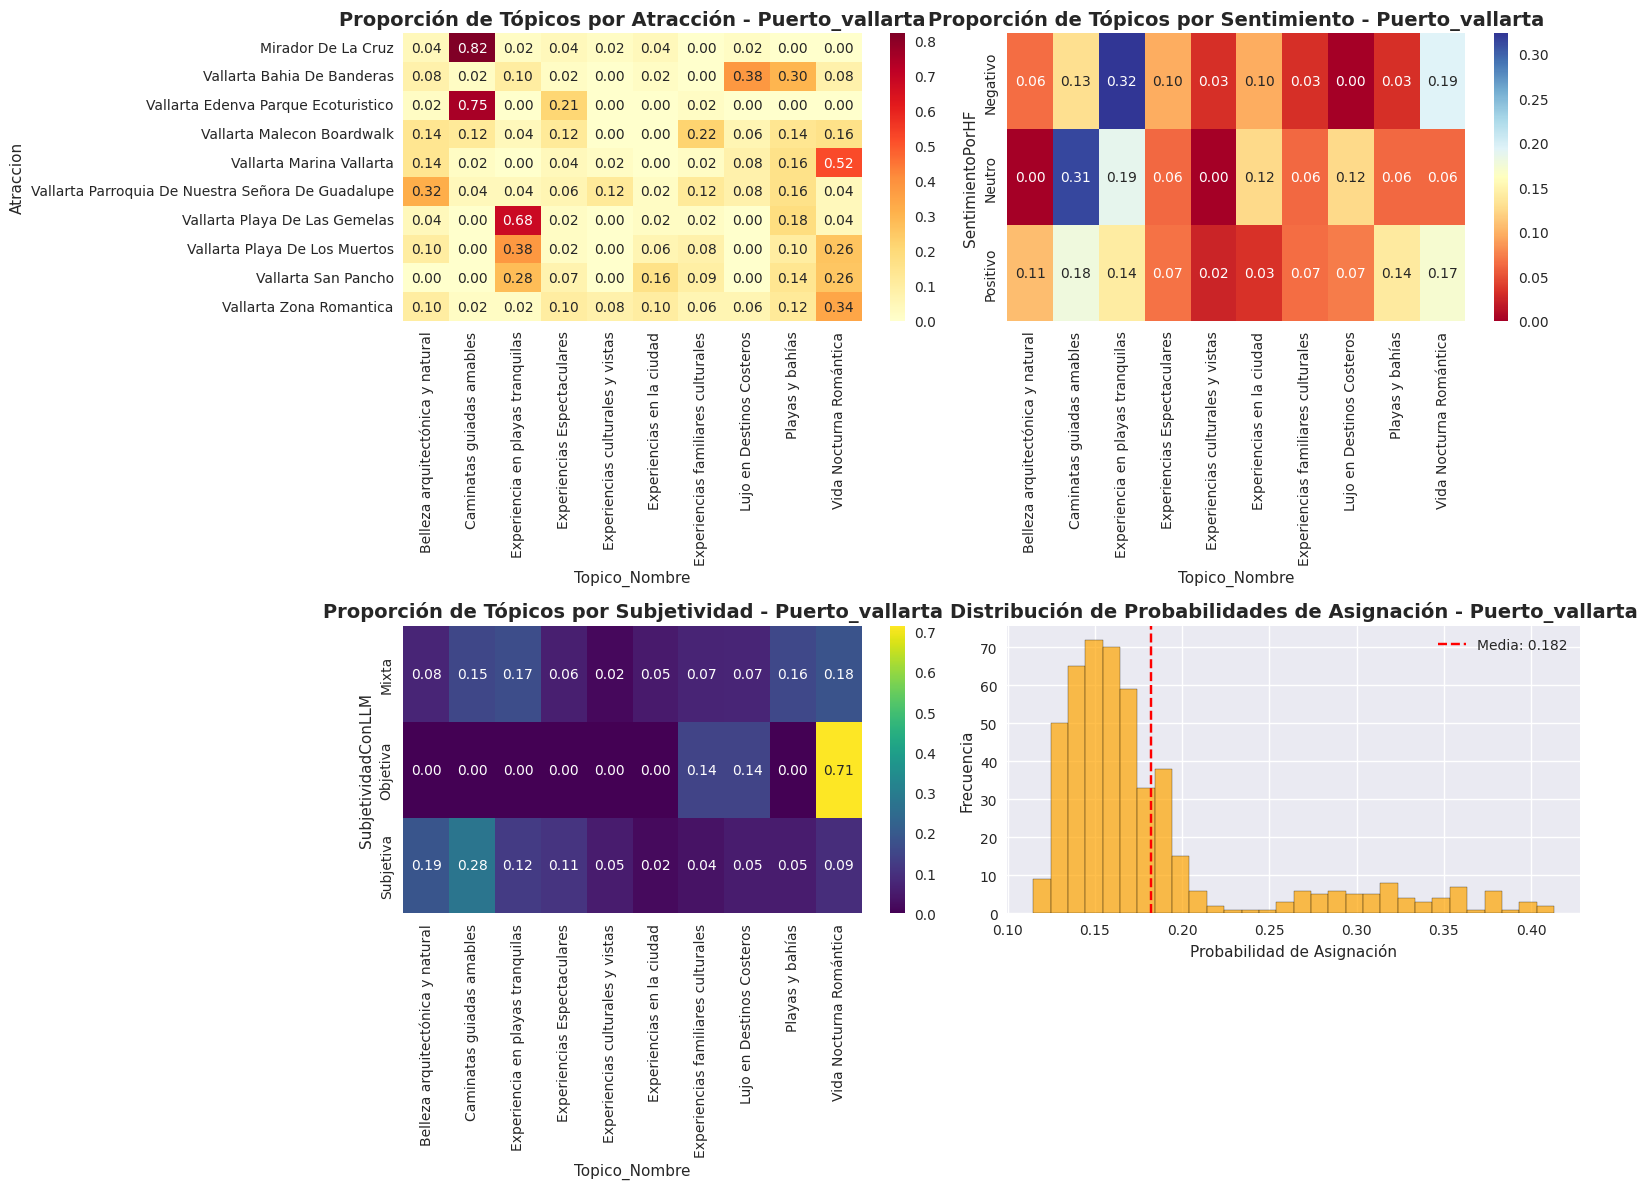

In [42]:
# Visualizaciones principales de FASTopic
visualizar_distribucion_topicos_fastopic(topic_info, CIUDAD_ANALIZAR, top_n=10)

# Comparación con otras variables
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Distribución por atracción en la ciudad
if len(df_con_topicos['Atraccion'].unique()) > 1:
    atraccion_topico = pd.crosstab(df_con_topicos['Atraccion'], df_con_topicos['Topico_Nombre'])
    atraccion_topico_norm = atraccion_topico.div(atraccion_topico.sum(axis=1), axis=0)
    sns.heatmap(atraccion_topico_norm, annot=True, fmt='.2f', ax=axes[0,0], cmap='YlOrRd')
    axes[0,0].set_title(f'Proporción de Tópicos por Atracción - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')
else:
    axes[0,0].text(0.5, 0.5, f'Solo una atracción en {CIUDAD_ANALIZAR}', ha='center', va='center', transform=axes[0,0].transAxes)
    axes[0,0].set_title(f'Distribución por Atracción - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')

# Gráfico 2: Tópicos por sentimiento
if 'SentimientoPorHF' in df_con_topicos.columns:
    sentimiento_topico = pd.crosstab(df_con_topicos['SentimientoPorHF'], df_con_topicos['Topico_Nombre'])
    sentimiento_topico_norm = sentimiento_topico.div(sentimiento_topico.sum(axis=1), axis=0)
    sns.heatmap(sentimiento_topico_norm, annot=True, fmt='.2f', ax=axes[0,1], cmap='RdYlBu')
    axes[0,1].set_title(f'Proporción de Tópicos por Sentimiento - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')

# Gráfico 3: Tópicos por subjetividad
if 'SubjetividadConLLM' in df_con_topicos.columns:
    subjetividad_topico = pd.crosstab(df_con_topicos['SubjetividadConLLM'], df_con_topicos['Topico_Nombre'])
    subjetividad_topico_norm = subjetividad_topico.div(subjetividad_topico.sum(axis=1), axis=0)
    sns.heatmap(subjetividad_topico_norm, annot=True, fmt='.2f', ax=axes[1,0], cmap='viridis')
    axes[1,0].set_title(f'Proporción de Tópicos por Subjetividad - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')

# Gráfico 4: Distribución de probabilidades
axes[1,1].hist(df_con_topicos['Probabilidad_Topico'], bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1,1].set_title(f'Distribución de Probabilidades de Asignación - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Probabilidad de Asignación')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].axvline(df_con_topicos['Probabilidad_Topico'].mean(), color='red', linestyle='--', 
                 label=f'Media: {df_con_topicos["Probabilidad_Topico"].mean():.3f}')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [43]:
# Mostrar ejemplos de opiniones por tópico
mostrar_ejemplos_por_topico_fastopic(
    df_con_topicos, 
    topico_col='Topico_Nombre',
    texto_col='TituloReview',
    n_ejemplos=3,
    top_n_topicos=5
)

📚 EJEMPLOS DE OPINIONES POR TÓPICO

🏷️ 1. Caminatas guiadas amables
📊 Total de opiniones: 88
📝 Ejemplos:
   1. Impresionado por la vista!. La caminata me llevó unos 20 minutos, comenzó en la calle Aldama. Thete ...
   2. Para algunos es cansada la subida,pero les aseguro que no se arrepentirán cuando lleguen y disfruten...
   3. Fuimos dos veces. Hay una colina empinada y luego más de 300 escalones para llegar a la cima. Sin em...
----------------------------------------------------------------------

🏷️ 2. Vida Nocturna Romántica
📊 Total de opiniones: 83
📝 Ejemplos:
   1. Gran puerto deportivo / malecón. Pasea por el malecón y admira la variedad de barcos. Numerosos rest...
   2. Área de diversión. Marina Vallarta no es solo un centro para cientos de barcos; es un destino vibran...
   3. Buena selección de restaurantes, la paseé varias veces. Fue tan agradable caminar una media milla de...
----------------------------------------------------------------------

🏷️ 3. Experiencia en pla

In [44]:
# ===== COMPARACIÓN TEXTO ORIGINAL VS TEXTO LIMPIO =====
if 'TituloReviewLimpio' in df_con_topicos.columns:
    print(f"🔍 Comparación de ejemplos - Original vs Limpio ({CIUDAD_ANALIZAR}):")
    print("=" * 80)
    
    # Seleccionar algunos ejemplos para mostrar la diferencia
    ejemplos_muestra = df_con_topicos.sample(n=min(10, len(df_con_topicos)))
    
    for i, (_, row) in enumerate(ejemplos_muestra.iterrows(), 1):
        print(f"\n📄 EJEMPLO {i} - Tópico: {row['Topico_Nombre']}")
        print(f"🔸 Original: {row['TituloReview']}")
        print(f"🔹 Limpio:   {row['TituloReviewLimpio']}")
        print(f"📊 Probabilidad: {row['Probabilidad_Topico']:.3f}")
        
        # Calcular estadísticas del ejemplo
        len_orig = len(str(row['TituloReview']))
        len_limpio = len(str(row['TituloReviewLimpio']))
        reduccion = ((len_orig-len_limpio)/len_orig*100) if len_orig > 0 else 0
        print(f"📉 Reducción: {len_orig} → {len_limpio} caracteres ({reduccion:.1f}%)")
        print("-" * 80)

🔍 Comparación de ejemplos - Original vs Limpio (Puerto_vallarta):

📄 EJEMPLO 1 - Tópico: Experiencia en playas tranquilas
🔸 Original: La mejor playa de Puerto Vallarta. Esta sin duda es la mejor playa de Vallarta, agua tranquila, clara y no muy profunda, excelente opción para visitar con la familia o amigos.
🔹 Limpio:   la mejor playa de puerto vallarta esta sin duda es la mejor playa de vallarta agua tranquila clara y no muy profunda excelente opcion para visitar con la familia o amigos
📊 Probabilidad: 0.158
📉 Reducción: 175 → 170 caracteres (2.9%)
--------------------------------------------------------------------------------

📄 EJEMPLO 2 - Tópico: Experiencia en playas tranquilas
🔸 Original: Playa desagradable con demasiados vendedores de chatarra. La playa era la peor de todos los tiempos, definitivamente la peor en fotovoltaica. Los vendedores ambulantes intentaban venderte algo cada minuto, tenías que ser grosero e ignorarlos. No es una playa agradable, hay hermosas playas fuera

In [45]:
# ===== VISUALIZACIONES ESPECÍFICAS DE FASTOPIC =====

# Generar visualización de tópicos
fig_topics = topic_model.visualize_topic(top_n=min(8, len(topic_info)))
fig_topics.update_layout(title=f"Palabras Principales por Tópico - {CIUDAD_ANALIZAR}")
fig_topics.show()

# Generar visualización de pesos de tópicos
fig_weights = topic_model.visualize_topic_weights(top_n=min(10, len(topic_info)))
fig_weights.update_layout(title=f"Distribución de Pesos de Tópicos - {CIUDAD_ANALIZAR}")
fig_weights.show()

# Generar jerarquía de tópicos si hay suficientes
if len(topic_info) >= 3:
    fig_hierarchy = topic_model.visualize_topic_hierarchy()
    fig_hierarchy.update_layout(title=f"Jerarquía de Tópicos - {CIUDAD_ANALIZAR}")
    fig_hierarchy.show()

print(f"\n📋 Resumen del modelado FASTopic:")
print(f"✅ Textos analizados: {len(texts)}")
print(f"🎯 Tópicos encontrados: {len(topic_info)}")
print(f"⏱️ Tiempo de entrenamiento: {tiempo_entrenamiento:.2f}s")
print(f"📊 Probabilidad promedio: {df_con_topicos['Probabilidad_Topico'].mean():.3f}")
print(f"📈 Distribución:")
for i, (topico, count) in enumerate(topico_counts.head(5).items()):
    print(f"   {i+1}. {topico}: {count} opiniones ({count/len(df_con_topicos)*100:.1f}%)")


📋 Resumen del modelado FASTopic:
✅ Textos analizados: 491
🎯 Tópicos encontrados: 10
⏱️ Tiempo de entrenamiento: 14.25s
📊 Probabilidad promedio: 0.182
📈 Distribución:
   1. Caminatas guiadas amables: 88 opiniones (17.9%)
   2. Vida Nocturna Romántica: 83 opiniones (16.9%)
   3. Experiencia en playas tranquilas: 76 opiniones (15.5%)
   4. Playas y bahías: 64 opiniones (13.0%)
   5. Belleza arquitectónica y natural: 49 opiniones (10.0%)


🔄 COMPARACIÓN FASTopic vs BERTopic en Puerto_vallarta
📊 Opiniones con ambos análisis: 491

🎯 NÚMERO DE TÓPICOS:
   BERTopic: 7
   FASTopic: 5


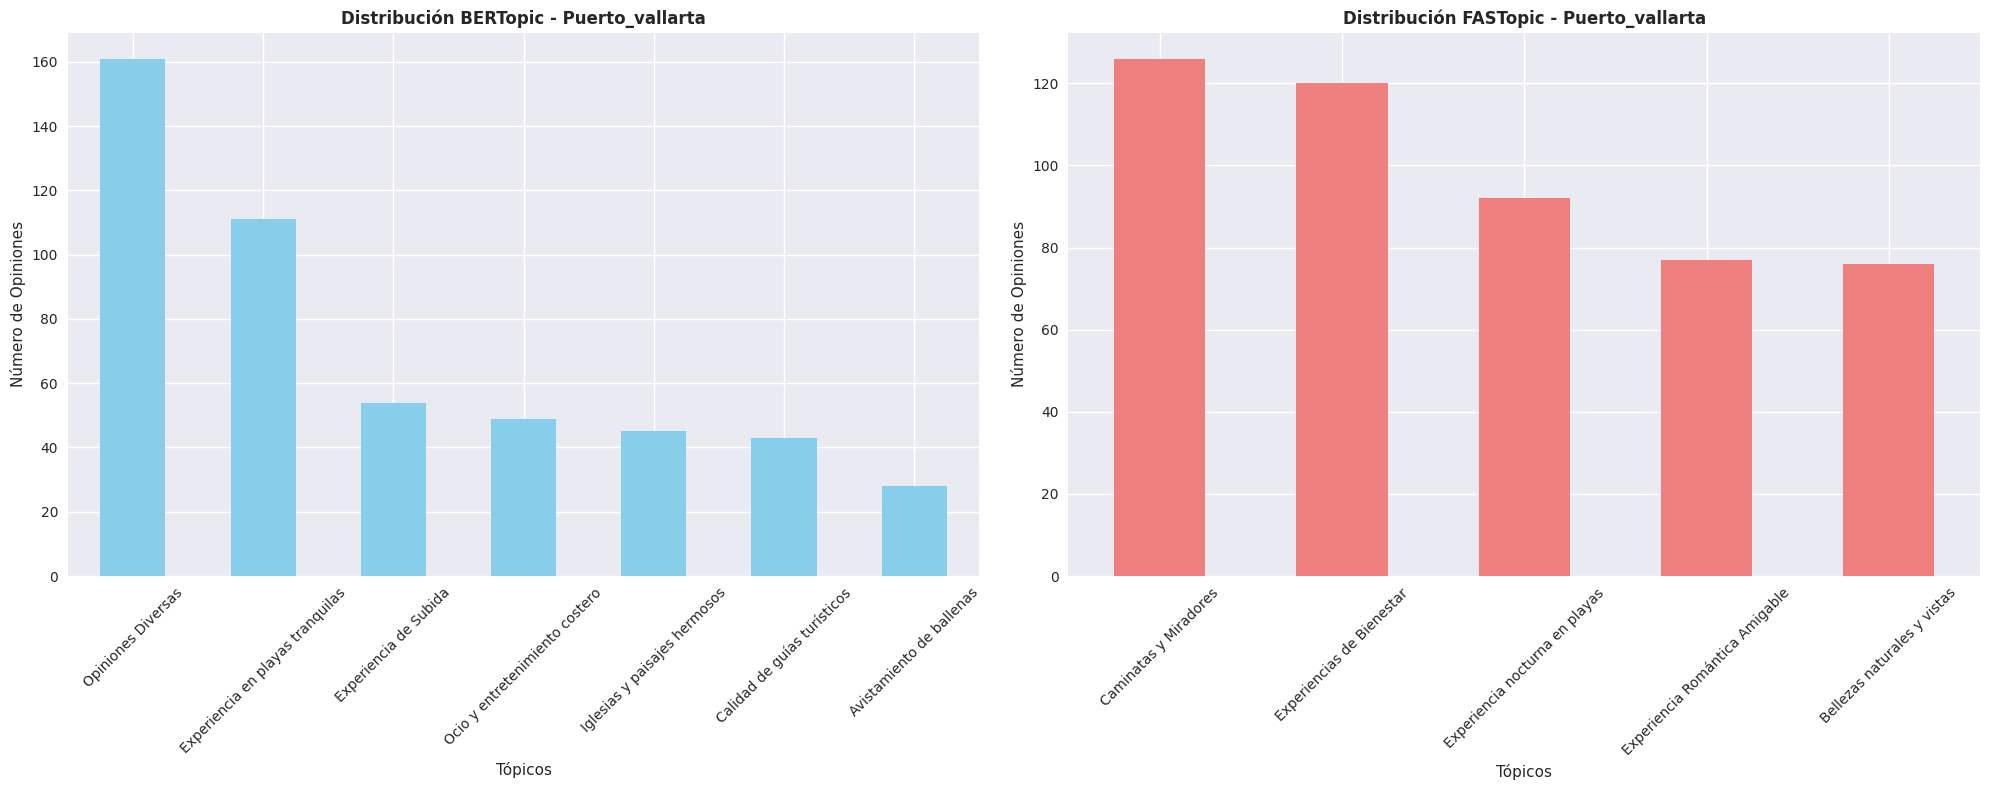


📈 TOP 5 TÓPICOS POR MÉTODO:

🔵 BERTopic:
   1. Opiniones Diversas: 161 (32.8%)
   2. Experiencia en playas tranquilas: 111 (22.6%)
   3. Experiencia de Subida: 54 (11.0%)
   4. Ocio y entretenimiento costero: 49 (10.0%)
   5. Iglesias y paisajes hermosos: 45 (9.2%)

🔴 FASTopic:
   1. Caminatas y Miradores: 126 (25.7%)
   2. Experiencias de Bienestar: 120 (24.4%)
   3. Experiencia nocturna en playas: 92 (18.7%)
   4. Experiencia Romántica Amigable: 77 (15.7%)
   5. Bellezas naturales y vistas: 76 (15.5%)

💡 OBSERVACIONES:
   • FASTopic identificó 5 tópicos vs 7 de BERTopic
   • FASTopic agrupa conceptos de manera más generalizada
   • Tiempo FASTopic: 14.25s (más rápido que BERTopic)


In [46]:
# ===== COMPARACIÓN CON BERTOPIC =====

if 'TopicoConBERTopic' in df.columns:
    print(f"🔄 COMPARACIÓN FASTopic vs BERTopic en {CIUDAD_ANALIZAR}")
    print("=" * 60)
    
    # Filtrar datos de la ciudad con ambos análisis
    df_comparacion = df_ciudad[
        (df_ciudad['TopicoConBERTopic'].notna()) & 
        (df_ciudad['TopicoConFASTopic'].notna())
    ].copy()
    
    if len(df_comparacion) > 0:
        print(f"📊 Opiniones con ambos análisis: {len(df_comparacion)}")
        
        # Comparar número de tópicos únicos
        topicos_bertopic = df_comparacion['TopicoConBERTopic'].nunique()
        topicos_fastopic = df_comparacion['TopicoConFASTopic'].nunique()
        
        print(f"\n🎯 NÚMERO DE TÓPICOS:")
        print(f"   BERTopic: {topicos_bertopic}")
        print(f"   FASTopic: {topicos_fastopic}")
        
        # Mostrar distribuciones lado a lado
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        # BERTopic
        bertopic_counts = df_comparacion['TopicoConBERTopic'].value_counts().head(10)
        bertopic_counts.plot(kind='bar', ax=axes[0], color='skyblue')
        axes[0].set_title(f'Distribución BERTopic - {CIUDAD_ANALIZAR}', fontweight='bold')
        axes[0].set_xlabel('Tópicos')
        axes[0].set_ylabel('Número de Opiniones')
        axes[0].tick_params(axis='x', rotation=45)
        
        # FASTopic
        fastopic_counts = df_comparacion['TopicoConFASTopic'].value_counts().head(10)
        fastopic_counts.plot(kind='bar', ax=axes[1], color='lightcoral')
        axes[1].set_title(f'Distribución FASTopic - {CIUDAD_ANALIZAR}', fontweight='bold')
        axes[1].set_xlabel('Tópicos')
        axes[1].set_ylabel('Número de Opiniones')
        axes[1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Análisis de concordancia (tópicos más frecuentes)
        print(f"\n📈 TOP 5 TÓPICOS POR MÉTODO:")
        print(f"\n🔵 BERTopic:")
        for i, (topico, count) in enumerate(bertopic_counts.head(5).items(), 1):
            pct = (count / len(df_comparacion) * 100)
            print(f"   {i}. {topico}: {count} ({pct:.1f}%)")
        
        print(f"\n🔴 FASTopic:")
        for i, (topico, count) in enumerate(fastopic_counts.head(5).items(), 1):
            pct = (count / len(df_comparacion) * 100)
            print(f"   {i}. {topico}: {count} ({pct:.1f}%)")
            
        print(f"\n💡 OBSERVACIONES:")
        print(f"   • FASTopic identificó {topicos_fastopic} tópicos vs {topicos_bertopic} de BERTopic")
        if topicos_fastopic > topicos_bertopic:
            print(f"   • FASTopic muestra mayor granularidad en la segmentación")
        elif topicos_fastopic < topicos_bertopic:
            print(f"   • FASTopic agrupa conceptos de manera más generalizada")
        else:
            print(f"   • Ambos métodos identificaron el mismo número de tópicos")
            
        print(f"   • Tiempo FASTopic: {tiempo_entrenamiento:.2f}s (más rápido que BERTopic)")
        
    else:
        print(f"⚠️ No hay opiniones de {CIUDAD_ANALIZAR} con ambos análisis completados")
        print(f"   BERTopic: {df_ciudad['TopicoConBERTopic'].notna().sum()} opiniones")
        print(f"   FASTopic: {df_ciudad['TopicoConFASTopic'].notna().sum()} opiniones")
else:
    print(f"ℹ️ No hay análisis previo de BERTopic para comparar")
    print(f"   Ejecuta el notebook 07-modelado-de-topicos-con-bertopic.ipynb primero")

In [47]:
# ===== REPORTE FINAL Y GUARDADO =====

# Generar reporte completo
generar_reporte_fastopic(
    topic_info, 
    len(df_con_topicos), 
    CIUDAD_ANALIZAR, 
    tiempo_entrenamiento
)

# Guardar dataset actualizado
print("\n💾 Guardando dataset actualizado...")
df.to_csv('../data/processed/dataset_opiniones_analisis.csv', index=False)

print("\n✅ Dataset actualizado y guardado:")
print(f"📁 Archivo: ../data/processed/dataset_opiniones_analisis.csv")
print(f"📊 Total opiniones: {len(df)}")
print(f"🎯 Ciudad analizada: {CIUDAD_ANALIZAR}")
print(f"✅ Opiniones con FASTopic: {df['TopicoConFASTopic'].notna().sum()}")
print(f"✅ Opiniones con BERTopic: {df['TopicoConBERTopic'].notna().sum() if 'TopicoConBERTopic' in df.columns else 0}")
print(f"⏳ Opiniones pendientes: {df['TopicoConFASTopic'].isna().sum()}")

print(f"\n📈 Estadísticas finales de {CIUDAD_ANALIZAR}:")
print(f"Tópicos FASTopic: {len(topic_info)}")
print(f"Opiniones analizadas: {len(df_con_topicos)}")
print(f"Tiempo total: {tiempo_entrenamiento:.2f}s")
print(f"Probabilidad promedio: {df_con_topicos['Probabilidad_Topico'].mean():.3f}")

print(f"\n🔄 Para analizar otra ciudad:")
print(f"1. Cambia la variable CIUDAD_ANALIZAR en la celda correspondiente")
print(f"2. Ejecuta nuevamente las celdas de análisis")
print(f"📍 Ciudades disponibles: {list(df['Ciudad'].unique())}")
print(f"⚠️ IMPORTANTE: Los resultados previos se SOBRESCRIBEN automáticamente")

📋 REPORTE COMPLETO - ANÁLISIS CON FASTOPIC
🎯 ANÁLISIS COMPLETADO:
   📍 Ciudad: Puerto_vallarta
   📄 Documentos analizados: 491
   🏷️ Tópicos identificados: 10
   ⏱️ Tiempo de entrenamiento: 14.25 segundos

📊 ESTADÍSTICAS DE TÓPICOS:
   🎯 Tópico más relevante: Playas y bahías
   📈 Peso máximo: 50.350
   📉 Peso mínimo: 48.625
   📊 Peso promedio: 49.100

🏆 TOP 5 TÓPICOS POR RELEVANCIA:
   1. Playas y bahías
      📊 Peso: 50.350 | 📄 Documentos: 80
      🔑 Palabras clave: the, and, for, bay, was, beach, there, were...
   2. Experiencias culturales y vistas
      📊 Peso: 49.998 | 📄 Documentos: 116
      🔑 Palabras clave: church, inside, cream, walking, boardwalk, view, a...
   3. Experiencias Espectaculares
      📊 Peso: 49.083 | 📄 Documentos: 239
      🔑 Palabras clave: espectacular, espectaculares, adriel, serviciales,...
   4. Caminatas guiadas amables
      📊 Peso: 48.948 | 📄 Documentos: 189
      🔑 Palabras clave: guias, subir, cima, caminata, amables, subida, esc...
   5. Lujo en Desti